# Binary classification of images

## Problem description:##

Our goal is to transform the multi-class classification problem (using famous MNIST dataset) into a binary. For this purpose, we combine 2 original MNIST images (digits, size =28x28) into one, after that each images contains 2 digits (new size = 56x28). So now we want to teach the neural network to find images that contain the number 4 (class=1, other images: class=0). 

In [210]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Image

import numpy as np
import random
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw

# the following line is not required if Dataset is installed as a python package.
sys.path.append("../..")
from dataset import Pipeline, B, C, F, V
import mnist
from dataset.models.tf import ResNet18
from dataset import DatasetIndex, Dataset, Batch

from dataset import B, V, F, R, P, action, ImagesBatch
from dataset.models.tf import TFModel
from dataset.models.tf.layers import conv_block
from dataset.batch_image import transform_actions

from dataset.opensets import MNIST

sys.path.append('../utils')
import utils

plt.style.use('seaborn-poster')
plt.style.use('ggplot')

---------------------------------------------------------------------------------------------


#### Define Batch class which holds data and contains processing functions ####
**(in our case we can choose any default class like ImagesBatch)** 

In [211]:
@transform_actions(prefix='_', suffix='_', wrapper='apply_transform')
class MnistBatch(ImagesBatch):
    components = 'images', 'labels'

    def _shift_flattened_(self, image, max_margin=8):
        padded = np.pad(self._to_array_(image),
                        pad_width=[[max_margin, max_margin], [max_margin, max_margin], [0, 0]],
                        mode='minimum')
        left_lower = np.random.randint(2 * max_margin, size=2)
        slicing = (slice(left_lower[0], left_lower[0] + 56),
                   slice(left_lower[1], left_lower[1] + 28))
        return self._to_pil_(padded[slicing])

---------------------------------------------------------------------------------------------

#### Let's load data and create the dataset using MNIST openset: ####

In [212]:
dataset=MNIST(batch_class=MnistBatch)

Downloadinghttp://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
 http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
Extracting /var/folders/ns/3lqd0mjj7vg1pt0gj5ph0nw80000gn/T/train-labels-idx1-ubyte.gzDownloading
Extracting /var/folders/ns/3lqd0mjj7vg1pt0gj5ph0nw80000gn/T/t10k-images-idx3-ubyte.gzExtracting http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
 /var/folders/ns/3lqd0mjj7vg1pt0gj5ph0nw80000gn/T/train-images-idx3-ubyte.gz

Extracting /var/folders/ns/3lqd0mjj7vg1pt0gj5ph0nw80000gn/T/t10k-labels-idx1-ubyte.gz



***Images and their labels are in preloaded.***

In [213]:
# odt = original data
odt=dataset.train.preloaded

***So "odt[0]" corresponds to a set of images and "odt[1]" corresponds to the list of labels***

---------------------------------------------------------------------------------------------

#### Sample pictures from the MNIST dataset: ####
![MNIST dataset](https://m-alcu.github.io/assets/mnist.png)  

---------------------------------------------------------------------------------------------

#### Create two lists - "four" and "others". #### 
**List "four" contains the indices of images of figure 4, list "others" - all the remaining indices**

In [215]:
four=[]
others=[]
for i in range(0, len(odt[1])):
    if odt[1][i]==4:
        four.append(i)
    else:
        others.append(i)
random.shuffle(others)

#### Create new images array (train_4), which contain images with number 4#####
**Also create labels array y_4 (all elements have class=1)**

In [216]:
# new_image_size 56 x 28
train_4 = odt[0][four[0]]
train_4 = np.append(train_4, odt[0][others[0]],axis=0)
zipped = zip(four, others[0:len(four)])
for i,j in zipped:
    if i != four[0]:
        train_4 = np.append(train_4, odt[0][i], axis=0)
        train_4 = np.append(train_4, odt[0][j], axis=0)
train_4 = train_4.reshape((len(four),56,28))
y_4 = np.ones((len(four)))

#### Create new images array (train_others), which contain images with other numbers#####
**Also create labels array y_others (all elements have class=0)**

In [217]:
train_others = odt[0][others[len(four)]]
for i in others[len(four):len(four)*3]:
    if i != others[len(four)]:
        train_others = np.append(train_others, odt[0][i], axis=0)
train_others = train_others.reshape((len(four),56,28))
y_others = np.zeros((len(four)))

#### Now let's combine the received arrays into one array ####

In [219]:
train_images_new = np.concatenate((train_4, train_others), axis=0)
train_labels_new = np.concatenate((y_4, y_others),axis=0)

#### Sample pictures after transformations ####

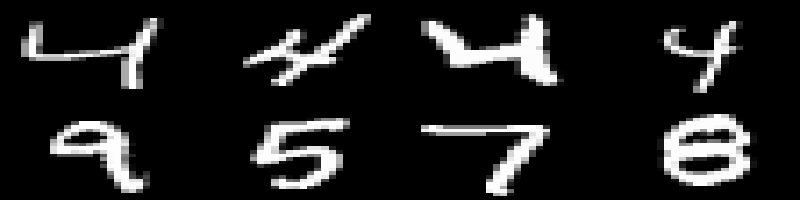

In [220]:
class_1 = Image.new('L', (800,200))

for i in range(0,4):
    class_1.paste(Image.fromarray(train_4[i]).resize([200,200]), (0+200*i,0))
class_1

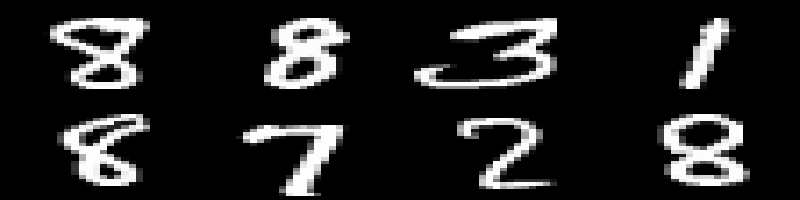

In [221]:
class_0 = Image.new('L', (800,200))

for i in range(0,4):
    class_0.paste(Image.fromarray(train_others[i]).resize([200,200]), (0+200*i,0))
class_0

#### Now we prepare to create a new dataset ####

In [222]:
new_MNIST_data = train_images_new, train_labels_new

In [120]:
new_MNIST_index = list(range(train_labels_new.shape[0]))
new_MNIST_dataset = Dataset(new_MNIST_index, batch_class=MnistBatch, preloaded=new_MNIST_data)
new_MNIST_dataset.cv_split([.8, .1, .1], shuffle=True)

#### For example, let's use config for ResNet18 model from dataset.models.tf ####

In [223]:
config = dict(model=ResNet18) 

#### When config is defined, next step is to create a pipeline. ####


*Also we add to default pipeline rotation transform. Now each image rotate with probability 0.5 by angle = 180 degree.*

*As a result, the position of figure 4 will not be the same [before this (as you can see in sample pictures) all figures 4 were at the top]*

*Due to this trasformation we have complicated the learning process, adding variance in data*

In [224]:
train_template = (Pipeline(config=config)
                .init_variable('loss_history', init_on_each_run=list)
                .init_variable('current_loss', init_on_each_run=0)
                .shift_flattened()
                .init_model('dynamic', C('model'), 'conv_nn',
                            config={'inputs': dict(images={'shape': B('image_shape')},
                                                   labels={'classes': 2, 'transform': 'ohe', 'name': 'targets'}),
                                    'input_block/inputs': 'images',
                                    'output': dict(ops=['accuracy'])})
                .rotate(angle=180, p=0.3)  
                .to_array()
                .train_model('conv_nn', fetches='loss',
                                     feed_dict={'images': B('images'),
                                                'labels': B('labels')},
                             save_to=V('current_loss'))
                .update_variable('loss_history', V('current_loss'), mode='a')
)

#### Train the model ####
**Apply a dataset to a template pipeline to create a runnable pipeline:**

In [225]:
train_pipeline = (train_template << new_MNIST_dataset.train)

** Run the pipeline:**

In [226]:
BATCH_SIZE = 32
train_pipeline.run(BATCH_SIZE, shuffle=True, n_epochs=1, drop_last=True, bar=True)

100%|██████████| 292/292 [06:33<00:00,  1.22s/it]


#### Test the model ####

In [228]:
test_pipeline = (new_MNIST_dataset.validation.p
                .import_model('conv_nn', train_pipeline)
                .init_variable('accuracy', init_on_each_run=list)
                .to_array()
                .init_variable('answers', init_on_each_run=list)
                .init_variable('img', init_on_each_run=list)
                .init_variable('predict', init_on_each_run=list)
                .predict_model('conv_nn', fetches=['output_accuracy','labels', 'images', 'output_labels'], 
                               feed_dict={'images': B('images'), 'labels': B('labels')},
                               save_to=[V('accuracy'),V('answers'),V('img'),V('predict')], mode='a')
                .run(BATCH_SIZE, shuffle=True, n_epochs=1, drop_last=True, bar=True)
)


100%|██████████| 36/36 [00:06<00:00,  5.63it/s]


#### Lest's find accuracy on test data ####

In [255]:
accuracy = np.array(test_pipeline.get_variable('accuracy')).mean()
#answers = np.array(test_pipeline.get_variable('answers'))
print('Accuracy {:6.2f}'.format(accuracy))

Accuracy   0.98


#### Finally, draw images with corresponding algorithm predictions and real answers ####

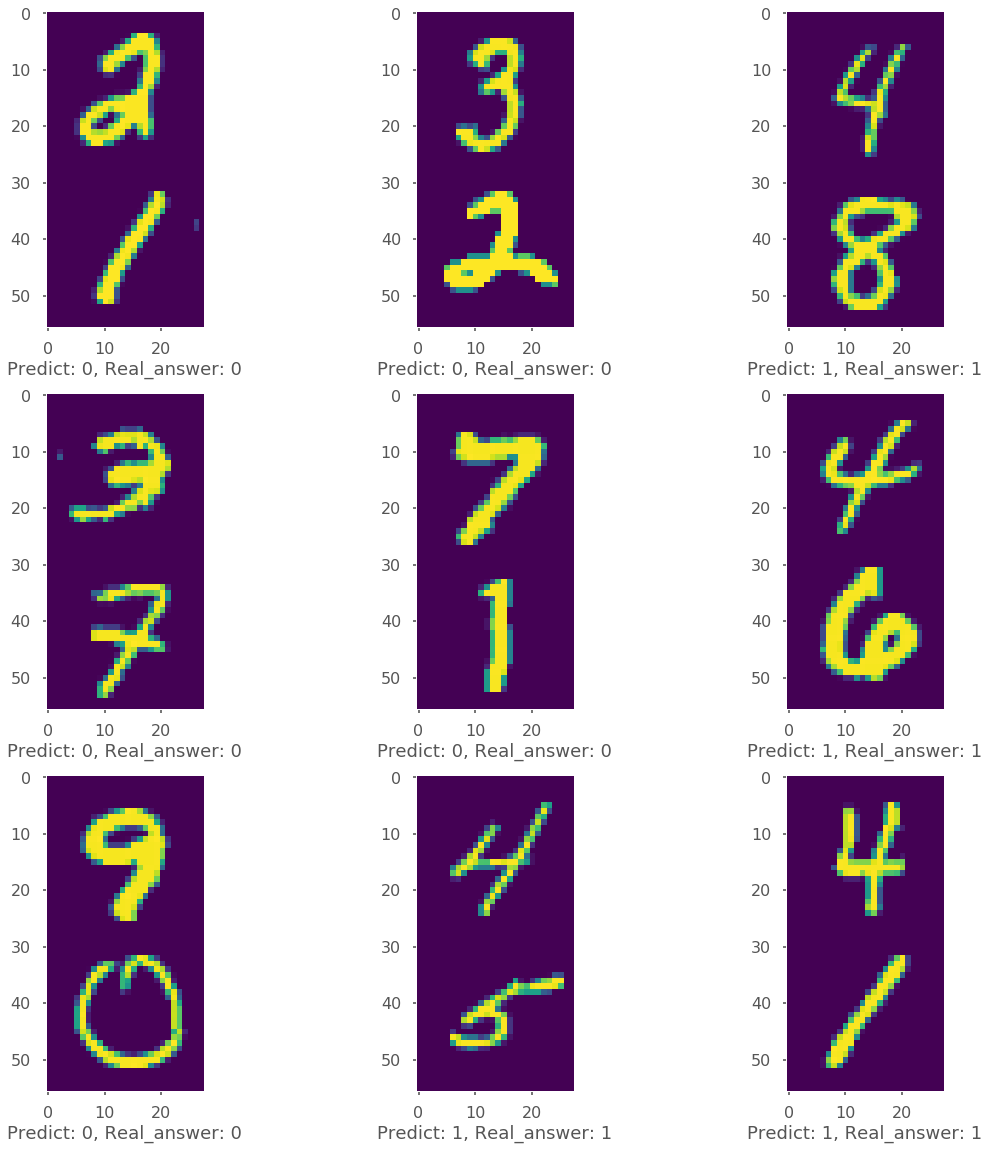

In [260]:
_, ax = plt.subplots(3, 3, figsize=(16, 16))
ax = ax.reshape(-1)


for num_batch in range(9):
    test_pipeline.next_batch(1, n_epochs=None, shuffle=True)
    answer= test_pipeline.get_variable('answers')
    img = test_pipeline.get_variable('img')
    predict = test_pipeline.get_variable('predict')
    ax[num_batch].imshow(img[-1].reshape(56, 28))
    ax[num_batch].set_xlabel('Predict: {}, Real_answer: {}' 
                             .format(predict[-1][0], answer[-1][0]),fontsize=18)
    ax[num_batch].grid()
plt.tight_layout(pad=0.8, w_pad=0.2, h_pad=1.0)
plt.show()